# Hotel Deals & Value Analysis - Deep Dive EDA v2

## 📋 IMPORTANT RULES & CONTEXT

### FHR (Fine Hotels & Resorts) Properties
**ALWAYS include by default:**
- ✓ Free Breakfast
- ✓ Late Check-out (4pm)
- ✓ Early Check-in (12pm)
- ✓ Room Upgrade (if available)

**Therefore:** Free breakfast is NOT a value differentiator for FHR properties.

### THC (The Hotel Collection) Properties
- Do NOT include free breakfast by default
- Free breakfast IS a significant value-add for THC

### Promotion Pricing Rules
1. **"Third Night Free" promos**: Already baked into pricing (we did 3-night searches)
2. **"Fourth/Fifth Night Free"**: NOT reflected in our rates (would need 4-5 night searches)
3. **Percent-off promos**: Already show the true discounted rate

### Pricing Considerations
- **Use `pricing_total_inclusive`** (includes taxes + fees)
- Taxes and fees vary SIGNIFICANTLY by country/city
- Can dramatically change the true cost and value proposition

### Rating Limitations
- **Star Rating**: Limited usefulness - almost all properties are 4-5 star
- **User Rating**: Need to validate if it correlates with value
- **Amenities**: Need to validate if they're meaningful differentiators

---

In [17]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime, timedelta
from pathlib import Path

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

# Database path
DB_PATH = Path('../data/storage/hotels.sqlite3')

# Connect to database
conn = sqlite3.connect(DB_PATH)
print(f"✓ Connected to database: {DB_PATH}")
print(f"Database size: {DB_PATH.stat().st_size / (1024**3):.2f} GB")

✓ Connected to database: ../data/storage/hotels.sqlite3
Database size: 20.44 GB


## 1. Database Overview & Data Volume

In [18]:
# Get table information
query = """
SELECT 
    name as table_name,
    type
FROM sqlite_master
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name;
"""

tables_info = pd.read_sql_query(query, conn)
print("\nDatabase Tables:")
print("="*80)

# Get row counts for each table
table_stats = []
for table in tables_info['table_name']:
    count_query = f"SELECT COUNT(*) as count FROM {table}"
    count = pd.read_sql_query(count_query, conn)['count'][0]
    table_stats.append({'Table': table, 'Row Count': f"{count:,}"})

stats_df = pd.DataFrame(table_stats)
print(stats_df.to_string(index=False))


Database Tables:
                 Table Row Count
          destinations       173
        hotel_features   313,480
hotel_program_benefits    15,236
      hotel_promotions     1,124
                hotels     2,820
                  meta         1
       rate_components 3,869,793
   rate_nightly_prices 2,191,722
        rate_snapshots   737,400
            room_types    18,229
       search_payloads    22,152
           search_runs    22,230


## 2. Search Runs Overview

In [19]:
# Analyze search runs and date coverage
date_query = """
SELECT 
    MIN(check_in) as earliest_check_in,
    MAX(check_in) as latest_check_in,
    COUNT(DISTINCT check_in) as unique_check_in_dates,
    COUNT(DISTINCT destination_key) as unique_destinations,
    COUNT(*) as total_search_runs,
    SUM(CASE WHEN status='complete' THEN 1 ELSE 0 END) as completed_runs,
    AVG(nights) as avg_nights,
    AVG(adults) as avg_adults,
    AVG(total_hotels) as avg_hotels_per_run,
    AVG(total_rates) as avg_rates_per_run
FROM search_runs;
"""

date_summary = pd.read_sql_query(date_query, conn)
print("\nSearch Runs Summary:")
print("="*80)
for col in date_summary.columns:
    print(f"{col:30s}: {date_summary[col].iloc[0]}")


Search Runs Summary:
earliest_check_in             : 2025-01-05
latest_check_in               : 2026-10-07
unique_check_in_dates         : 358
unique_destinations           : 173
total_search_runs             : 22230
completed_runs                : 22150
avg_nights                    : 2.997165991902834
avg_adults                    : 2.0
avg_hotels_per_run            : 19.602519118308592
avg_rates_per_run             : 60.51664417453891


## 3. Load Rate Data (Using Inclusive Pricing)

In [20]:
# Load rate data - USING pricing_total_inclusive which includes taxes & fees
rates_query = """
SELECT 
    rs.id as snapshot_id,
    rs.run_id,
    sr.check_in,
    sr.check_out,
    sr.nights,
    sr.adults,
    sr.destination_name,
    sr.destination_group,
    sr.program_filter,
    h.property_id,
    h.name as hotel_name,
    h.star_rating,
    h.user_rating,
    h.user_rating_count,
    h.brand_name,
    h.chain_name,
    h.address_city,
    h.address_country_name,
    rt.name as room_type_name,
    rs.pricing_currency,
    rs.pricing_total,
    rs.pricing_total_inclusive,
    rs.pricing_base,
    rs.pricing_total_fees,
    rs.pricing_total_taxes,
    rs.average_nightly_rate,
    rs.is_breakfast_included,
    rs.is_food_beverage_credit,
    rs.is_free_cancellation,
    rs.is_parking_included,
    rs.is_shuttle_included,
    rs.payment_model,
    rs.points_burn,
    rs.hotel_collection,
    rs.special_offer_json,
    rs.available
FROM rate_snapshots rs
JOIN search_runs sr ON rs.run_id = sr.id
JOIN hotels h ON rs.property_id = h.property_id
LEFT JOIN room_types rt ON rs.property_id = rt.property_id AND rs.room_type_id = rt.room_type_id
WHERE sr.status = 'complete'
    AND rs.pricing_total_inclusive IS NOT NULL
    AND rs.pricing_total_inclusive > 0
LIMIT 200000;
"""

print("Loading rate data (using inclusive pricing with taxes & fees)...")
rates_df = pd.read_sql_query(rates_query, conn)
print(f"✓ Loaded {len(rates_df):,} rate snapshots")

# Convert dates
rates_df['check_in'] = pd.to_datetime(rates_df['check_in'])
rates_df['check_out'] = pd.to_datetime(rates_df['check_out'])

# Calculate inclusive price per night
rates_df['price_per_night_inclusive'] = rates_df['pricing_total_inclusive'] / rates_df['nights']

# Identify collection type
rates_df['is_fhr'] = rates_df['hotel_collection'].fillna('').str.contains('FHR', case=False, na=False).astype(int)
rates_df['is_thc'] = rates_df['hotel_collection'].fillna('').str.contains('THC', case=False, na=False).astype(int)
rates_df['collection_type'] = 'Standard'
rates_df.loc[rates_df['is_fhr'] == 1, 'collection_type'] = 'FHR'
rates_df.loc[rates_df['is_thc'] == 1, 'collection_type'] = 'THC'

print(f"\nCollection Distribution:")
print(rates_df['collection_type'].value_counts())

# Display sample
print("\nSample of rate data:")
display(rates_df[['hotel_name', 'check_in', 'collection_type', 'price_per_night_inclusive', 
                   'is_breakfast_included', 'user_rating']].head(10))

Loading rate data (using inclusive pricing with taxes & fees)...
✓ Loaded 200,000 rate snapshots

Collection Distribution:
collection_type
FHR    147090
THC     52910
Name: count, dtype: int64

Sample of rate data:


,hotel_name,check_in,collection_type,price_per_night_inclusive,is_breakfast_included,user_rating
0,The Peninsula Tokyo,2026-01-01,FHR,2241.87,0,4.6
1,The Peninsula Tokyo,2026-01-01,FHR,2320.44,0,4.6
2,Andaz Tokyo Toranomon Hills - a concept by Hyatt,2026-01-01,FHR,1375.40,0,4.6
3,Andaz Tokyo Toranomon Hills - a concept by Hyatt,2026-01-01,FHR,1402.68,0,4.6
4,Grand Hyatt Tokyo,2026-01-01,FHR,1301.79,0,4.6
5,Grand Hyatt Tokyo,2026-01-01,FHR,1343.15,0,4.6
6,Fuji Speedway Hotel - The Unbound Collection b...,2026-01-01,FHR,663.61,0,NaN
7,Fuji Speedway Hotel - The Unbound Collection b...,2026-01-01,FHR,663.61,0,NaN
8,Conrad Osaka,2026-01-01,FHR,1030.03,0,4.7
9,Conrad Osaka,2026-01-01,FHR,1030.03,0,4.7


## 4. Pricing Analysis - Understanding True Costs


💰 PRICING ANALYSIS (Taxes & Fees Impact):
Average base price (3 nights): $2888.14
Average inclusive price (3 nights): $2937.16
Average tax/fee amount: $49.02
Average tax/fee percentage: 2.4%

Max tax/fee percentage: 153.7%
Min tax/fee percentage: 0.0%

Top 15 Countries by Tax/Fee Percentage:
                          tax_fee_percentage  count
address_country_name                               
Maldives                           16.578169    732
Puerto Rico                        14.965004    444
Honduras                           12.540643     54
Netherlands                        10.229120   1023
Seychelles                          8.170545    275
United States of America            7.503138  47143
Tanzania                            7.016150    189
US Virgin Islands                   6.073721    112
Iceland                             5.569799     98
Cayman Islands                      5.511044    715
Aruba                               5.023721    661
St Kitts and Nevis            

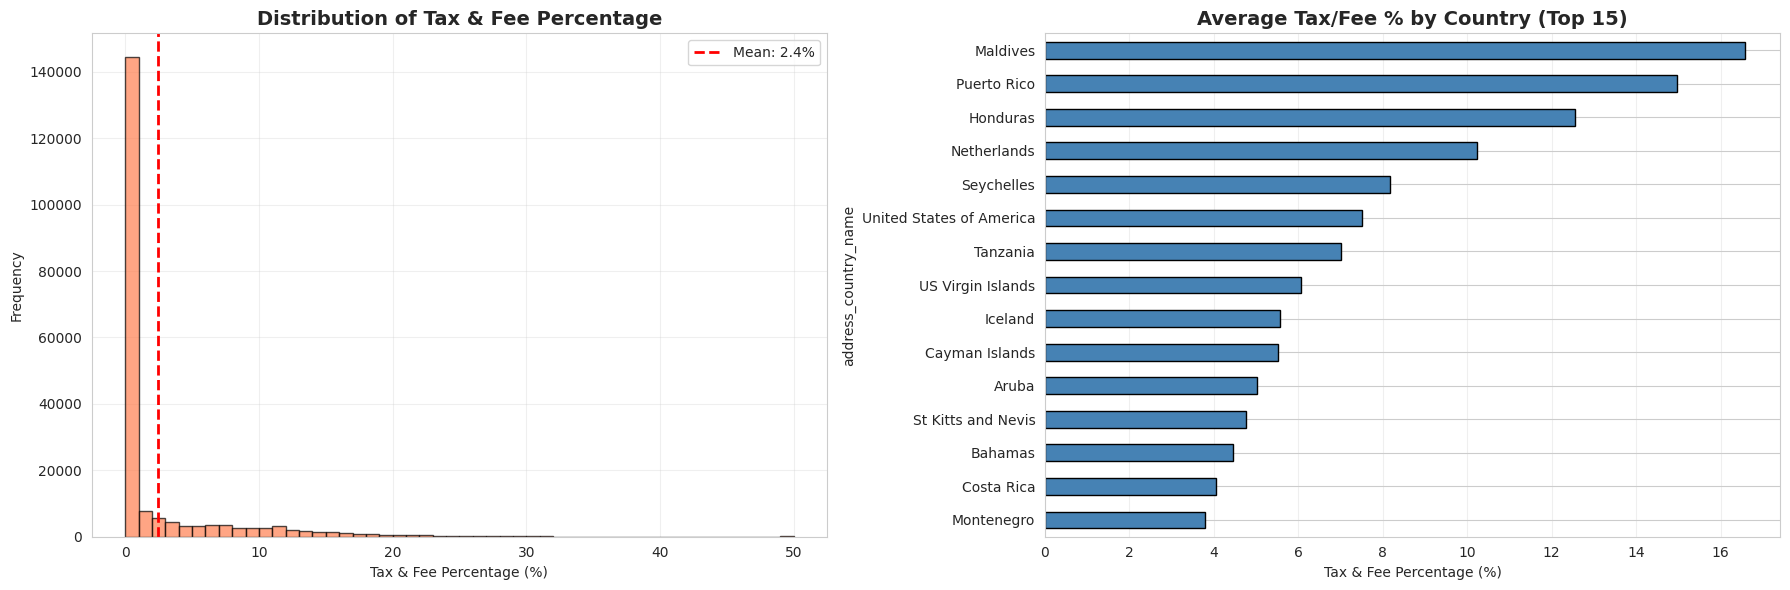

In [21]:
# Analyze the impact of taxes and fees
rates_df['tax_fee_amount'] = rates_df['pricing_total_inclusive'] - rates_df['pricing_total']
rates_df['tax_fee_percentage'] = (rates_df['tax_fee_amount'] / rates_df['pricing_total']) * 100

print("\n💰 PRICING ANALYSIS (Taxes & Fees Impact):")
print("="*80)
print(f"Average base price (3 nights): ${rates_df['pricing_total'].mean():.2f}")
print(f"Average inclusive price (3 nights): ${rates_df['pricing_total_inclusive'].mean():.2f}")
print(f"Average tax/fee amount: ${rates_df['tax_fee_amount'].mean():.2f}")
print(f"Average tax/fee percentage: {rates_df['tax_fee_percentage'].mean():.1f}%")
print(f"\nMax tax/fee percentage: {rates_df['tax_fee_percentage'].max():.1f}%")
print(f"Min tax/fee percentage: {rates_df['tax_fee_percentage'].min():.1f}%")

# Tax/fee distribution by country
tax_by_country = rates_df.groupby('address_country_name').agg({
    'tax_fee_percentage': 'mean',
    'snapshot_id': 'count'
}).rename(columns={'snapshot_id': 'count'}).sort_values('tax_fee_percentage', ascending=False).head(15)

print("\nTop 15 Countries by Tax/Fee Percentage:")
print(tax_by_country)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Tax/fee percentage distribution
axes[0].hist(rates_df['tax_fee_percentage'].clip(0, 50), bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0].axvline(rates_df['tax_fee_percentage'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {rates_df["tax_fee_percentage"].mean():.1f}%')
axes[0].set_title('Distribution of Tax & Fee Percentage', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tax & Fee Percentage (%)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Top countries
tax_by_country['tax_fee_percentage'].plot(kind='barh', ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('Average Tax/Fee % by Country (Top 15)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tax & Fee Percentage (%)')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 5. Validate: Do User Ratings Correlate with Value?

/tmp/ipykernel_13266/2550059928.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_price_stats = user_rating_analysis.groupby('rating_bin').agg({



⭐ USER RATING vs PRICE ANALYSIS:
           price_per_night_inclusive                 user_rating
                                mean   median  count        mean
rating_bin                                                      
<3.5                         1336.15  1488.70   1508        2.95
3.5-4.0                       669.08   632.87   5660        3.84
4.0-4.3                       738.04   580.85  25257        4.23
4.3-4.5                       829.71   654.27  45696        4.45
4.5-4.7                       928.79   661.72  64744        4.65
4.7+                         1183.47   815.66  37598        4.85

Correlation between user rating and price: 0.023
⚠️  WEAK correlation - user rating may not be a strong value indicator


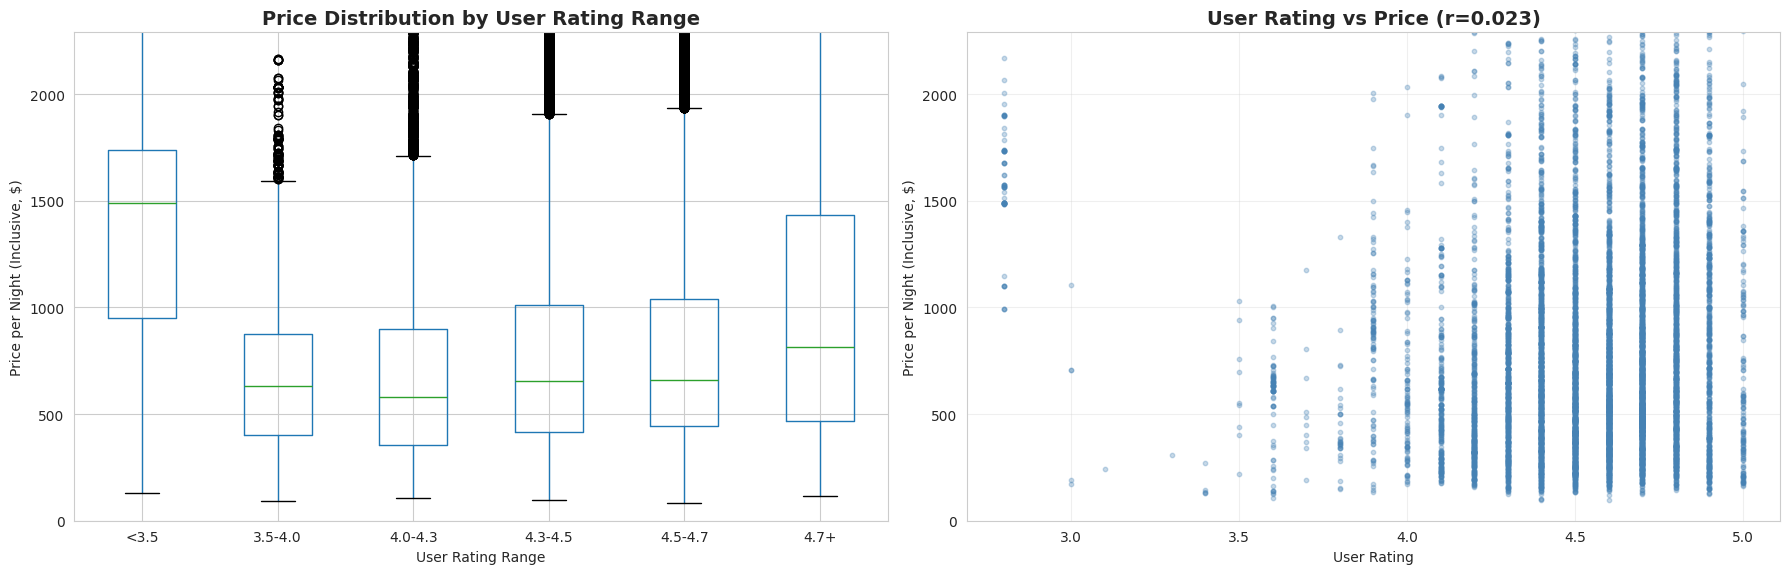

In [22]:
# Analyze user rating vs price relationship
user_rating_analysis = rates_df[rates_df['user_rating'].notna()].copy()

# Group by user rating bins
user_rating_analysis['rating_bin'] = pd.cut(user_rating_analysis['user_rating'], 
                                              bins=[0, 3.5, 4.0, 4.3, 4.5, 4.7, 5.0],
                                              labels=['<3.5', '3.5-4.0', '4.0-4.3', '4.3-4.5', '4.5-4.7', '4.7+'])

rating_price_stats = user_rating_analysis.groupby('rating_bin').agg({
    'price_per_night_inclusive': ['mean', 'median', 'count'],
    'user_rating': 'mean'
}).round(2)

print("\n⭐ USER RATING vs PRICE ANALYSIS:")
print("="*80)
print(rating_price_stats)

# Calculate correlation
correlation = rates_df[['user_rating', 'price_per_night_inclusive']].corr().iloc[0, 1]
print(f"\nCorrelation between user rating and price: {correlation:.3f}")
if abs(correlation) < 0.3:
    print("⚠️  WEAK correlation - user rating may not be a strong value indicator")
elif abs(correlation) < 0.7:
    print("✓ MODERATE correlation - user rating has some relationship to price")
else:
    print("✓ STRONG correlation - user rating strongly related to price")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Box plot by rating bin
user_rating_analysis.boxplot(column='price_per_night_inclusive', by='rating_bin', ax=axes[0])
axes[0].set_title('Price Distribution by User Rating Range', fontsize=14, fontweight='bold')
axes[0].set_xlabel('User Rating Range')
axes[0].set_ylabel('Price per Night (Inclusive, $)')
axes[0].set_ylim(0, user_rating_analysis['price_per_night_inclusive'].quantile(0.95))
plt.suptitle('')  # Remove default title

# Scatter plot (sample for performance)
sample = user_rating_analysis.sample(min(10000, len(user_rating_analysis)))
axes[1].scatter(sample['user_rating'], sample['price_per_night_inclusive'], 
                alpha=0.3, s=10, c='steelblue')
axes[1].set_title(f'User Rating vs Price (r={correlation:.3f})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('User Rating')
axes[1].set_ylabel('Price per Night (Inclusive, $)')
axes[1].set_ylim(0, user_rating_analysis['price_per_night_inclusive'].quantile(0.95))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Validate: Are Amenities Meaningful Differentiators?


🎁 AMENITY ANALYSIS BY COLLECTION TYPE:
                    FHR   THC  Standard
Breakfast          15.2   5.2       NaN
F&B Credit          0.0   0.3       NaN
Free Cancellation  81.9  81.8       NaN
Parking            43.1  21.9       NaN
Shuttle             0.0   0.0       NaN

⚠️  Note: FHR properties ALWAYS include breakfast by default (plus late checkout, early checkin, upgrades)
    Therefore, breakfast is only a value differentiator for THC and Standard properties.


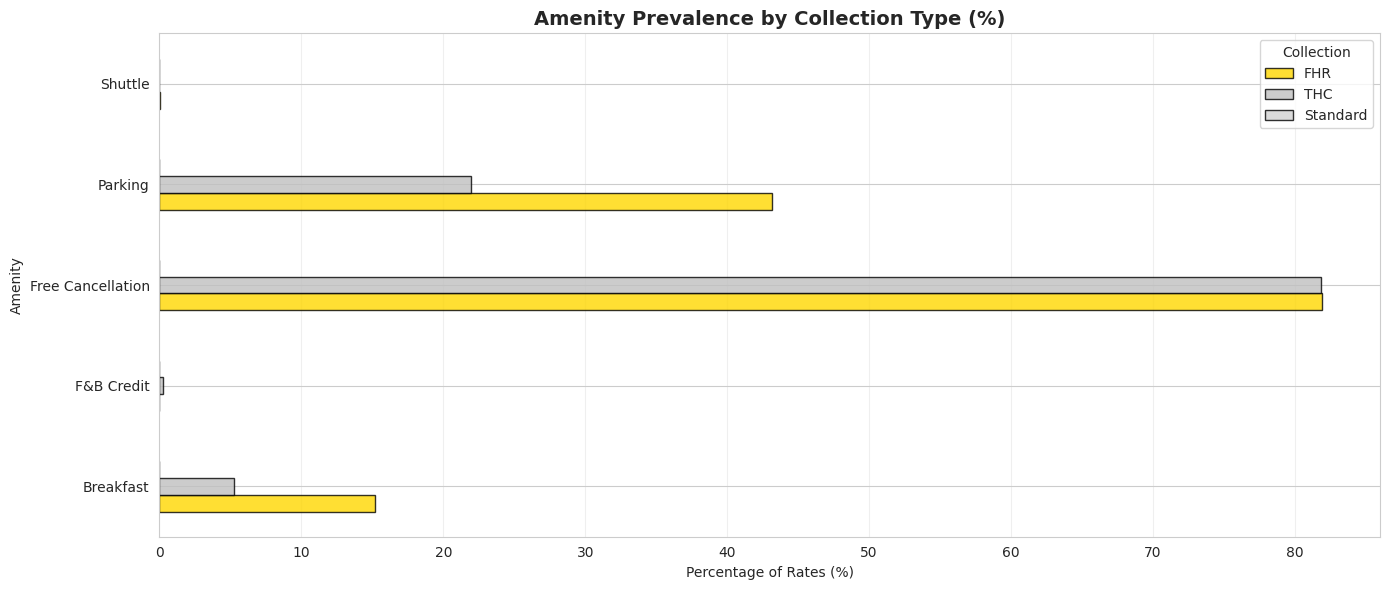


THC: Price with/without Breakfast:
                             mean      median  count
is_breakfast_included                               
0                      498.472715  408.210000  50133
1                      743.625930  593.203333   2777

Average price premium for breakfast in THC: $245.15/night


In [23]:
# Analyze amenities by collection type (remember: FHR always has breakfast!)
amenity_by_collection = pd.DataFrame({
    'FHR': [
        rates_df[rates_df['collection_type']=='FHR']['is_breakfast_included'].mean() * 100,
        rates_df[rates_df['collection_type']=='FHR']['is_food_beverage_credit'].mean() * 100,
        rates_df[rates_df['collection_type']=='FHR']['is_free_cancellation'].mean() * 100,
        rates_df[rates_df['collection_type']=='FHR']['is_parking_included'].mean() * 100,
        rates_df[rates_df['collection_type']=='FHR']['is_shuttle_included'].mean() * 100,
    ],
    'THC': [
        rates_df[rates_df['collection_type']=='THC']['is_breakfast_included'].mean() * 100,
        rates_df[rates_df['collection_type']=='THC']['is_food_beverage_credit'].mean() * 100,
        rates_df[rates_df['collection_type']=='THC']['is_free_cancellation'].mean() * 100,
        rates_df[rates_df['collection_type']=='THC']['is_parking_included'].mean() * 100,
        rates_df[rates_df['collection_type']=='THC']['is_shuttle_included'].mean() * 100,
    ],
    'Standard': [
        rates_df[rates_df['collection_type']=='Standard']['is_breakfast_included'].mean() * 100,
        rates_df[rates_df['collection_type']=='Standard']['is_food_beverage_credit'].mean() * 100,
        rates_df[rates_df['collection_type']=='Standard']['is_free_cancellation'].mean() * 100,
        rates_df[rates_df['collection_type']=='Standard']['is_parking_included'].mean() * 100,
        rates_df[rates_df['collection_type']=='Standard']['is_shuttle_included'].mean() * 100,
    ]
}, index=['Breakfast', 'F&B Credit', 'Free Cancellation', 'Parking', 'Shuttle'])

print("\n🎁 AMENITY ANALYSIS BY COLLECTION TYPE:")
print("="*80)
print(amenity_by_collection.round(1))
print("\n⚠️  Note: FHR properties ALWAYS include breakfast by default (plus late checkout, early checkin, upgrades)")
print("    Therefore, breakfast is only a value differentiator for THC and Standard properties.")

# Visualize
amenity_by_collection.plot(kind='barh', figsize=(14, 6), 
                            color=['gold', 'silver', 'lightgray'], 
                            alpha=0.8, edgecolor='black')
plt.title('Amenity Prevalence by Collection Type (%)', fontsize=14, fontweight='bold')
plt.xlabel('Percentage of Rates (%)')
plt.ylabel('Amenity')
plt.legend(title='Collection')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Analyze price difference with/without breakfast for THC
thc_rates = rates_df[rates_df['collection_type'] == 'THC'].copy()
if len(thc_rates) > 0:
    thc_breakfast_price = thc_rates.groupby('is_breakfast_included')['price_per_night_inclusive'].agg(['mean', 'median', 'count'])
    print("\nTHC: Price with/without Breakfast:")
    print(thc_breakfast_price)
    if 0 in thc_breakfast_price.index and 1 in thc_breakfast_price.index:
        price_diff = thc_breakfast_price.loc[1, 'mean'] - thc_breakfast_price.loc[0, 'mean']
        print(f"\nAverage price premium for breakfast in THC: ${price_diff:.2f}/night")

## 7. Star Rating Analysis - Validate Limited Usefulness


⭐ STAR RATING DISTRIBUTION:
star_rating
0.0      1760
2.0        39
2.5        40
3.0       159
3.5      1653
4.0     23799
4.5     18427
5.0    154123
Name: count, dtype: int64

Percentage 4+ stars: 98.2%
Percentage 5 stars: 77.1%


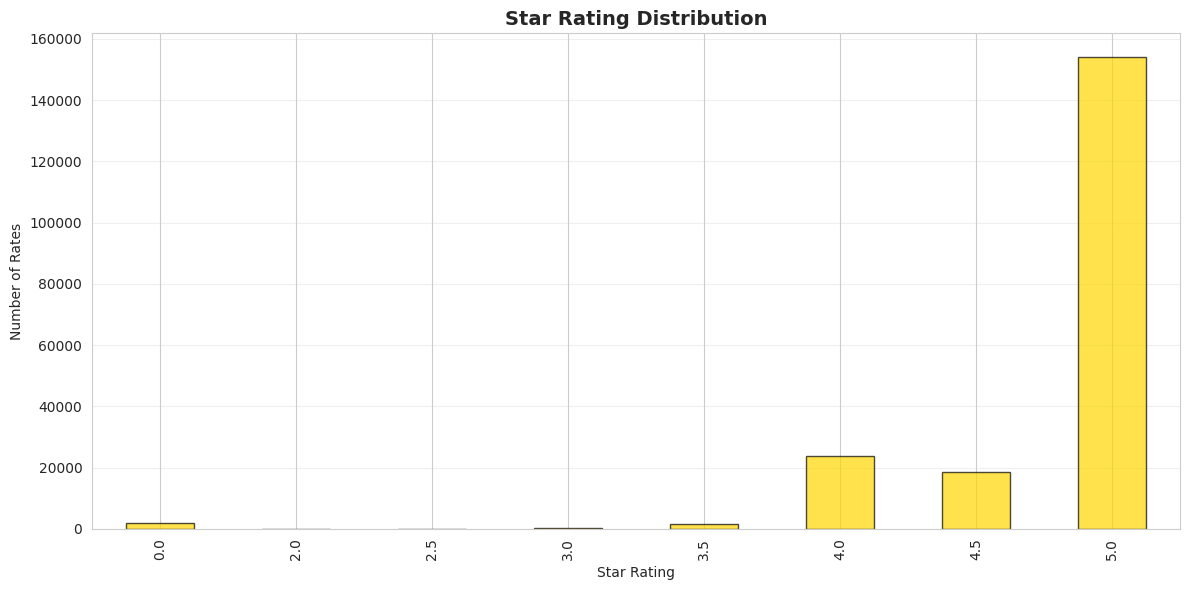


⚠️  CONCLUSION: Star rating has limited usefulness - over 80% are 4+ stars


In [24]:
# Confirm that most properties are 4-5 star
star_distribution = rates_df['star_rating'].value_counts().sort_index()

print("\n⭐ STAR RATING DISTRIBUTION:")
print("="*80)
print(star_distribution)
print(f"\nPercentage 4+ stars: {(rates_df['star_rating'] >= 4).sum() / len(rates_df) * 100:.1f}%")
print(f"Percentage 5 stars: {(rates_df['star_rating'] == 5).sum() / len(rates_df) * 100:.1f}%")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
star_distribution.plot(kind='bar', ax=ax, color='gold', alpha=0.7, edgecolor='black')
ax.set_title('Star Rating Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Star Rating')
ax.set_ylabel('Number of Rates')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

if (rates_df['star_rating'] >= 4).sum() / len(rates_df) > 0.8:
    print("\n⚠️  CONCLUSION: Star rating has limited usefulness - over 80% are 4+ stars")

## 8. 📅 TEMPORAL ANALYSIS - DEEP DIVE (Expanded!)

This is the most valuable section for finding deals based on timing.

In [25]:
# Comprehensive temporal analysis
temporal_df = rates_df.groupby(rates_df['check_in'].dt.date).agg({
    'snapshot_id': 'count',
    'price_per_night_inclusive': ['mean', 'median', 'min', 'std'],
    'property_id': 'nunique',
    'destination_name': 'nunique'
}).round(2)

temporal_df.columns = ['rate_count', 'avg_price', 'median_price', 'min_price', 'price_std', 'unique_hotels', 'unique_destinations']
temporal_df.index = pd.to_datetime(temporal_df.index)

# Add day of week
temporal_df['day_of_week'] = temporal_df.index.dayofweek
temporal_df['day_name'] = temporal_df.index.day_name()

# Add week number and month
temporal_df['week'] = temporal_df.index.isocalendar().week
temporal_df['month'] = temporal_df.index.month
temporal_df['month_name'] = temporal_df.index.month_name()

print("\n📅 TEMPORAL PRICE ANALYSIS:")
print("="*80)
print(f"Date range: {temporal_df.index.min()} to {temporal_df.index.max()}")
print(f"Total days covered: {len(temporal_df)}")
print(f"\nOverall Statistics:")
print(f"  Average price/night: ${temporal_df['avg_price'].mean():.2f}")
print(f"  Lowest average: ${temporal_df['avg_price'].min():.2f} on {temporal_df['avg_price'].idxmin()}")
print(f"  Highest average: ${temporal_df['avg_price'].max():.2f} on {temporal_df['avg_price'].idxmax()}")

display(temporal_df.head(10))


📅 TEMPORAL PRICE ANALYSIS:
Date range: 2025-01-05 00:00:00 to 2026-09-30 00:00:00
Total days covered: 335

Overall Statistics:
  Average price/night: $1087.14
  Lowest average: $766.86 on 2026-08-03 00:00:00
  Highest average: $1733.83 on 2026-04-03 00:00:00


,rate_count,avg_price,median_price,min_price,price_std,unique_hotels,unique_destinations,day_of_week,day_name,week,month,month_name
check_in,,,,,,,,,,,,
2025-01-05,93,786.94,618.4,190.4,477.12,48,1,6,Sunday,1,1,January
2025-01-06,93,786.94,618.4,190.4,477.12,48,1,0,Monday,2,1,January
2025-01-07,93,786.94,618.4,190.4,477.12,48,1,1,Tuesday,2,1,January
2025-01-08,93,786.94,618.4,190.4,477.12,48,1,2,Wednesday,2,1,January
2025-01-09,93,786.94,618.4,190.4,477.12,48,1,3,Thursday,2,1,January
2025-01-10,93,786.94,618.4,190.4,477.12,48,1,4,Friday,2,1,January
2025-01-11,93,786.94,618.4,190.4,477.12,48,1,5,Saturday,2,1,January
2025-01-12,93,786.94,618.4,190.4,477.12,48,1,6,Sunday,2,1,January
2025-01-13,93,786.94,618.4,190.4,477.12,48,1,0,Monday,3,1,January


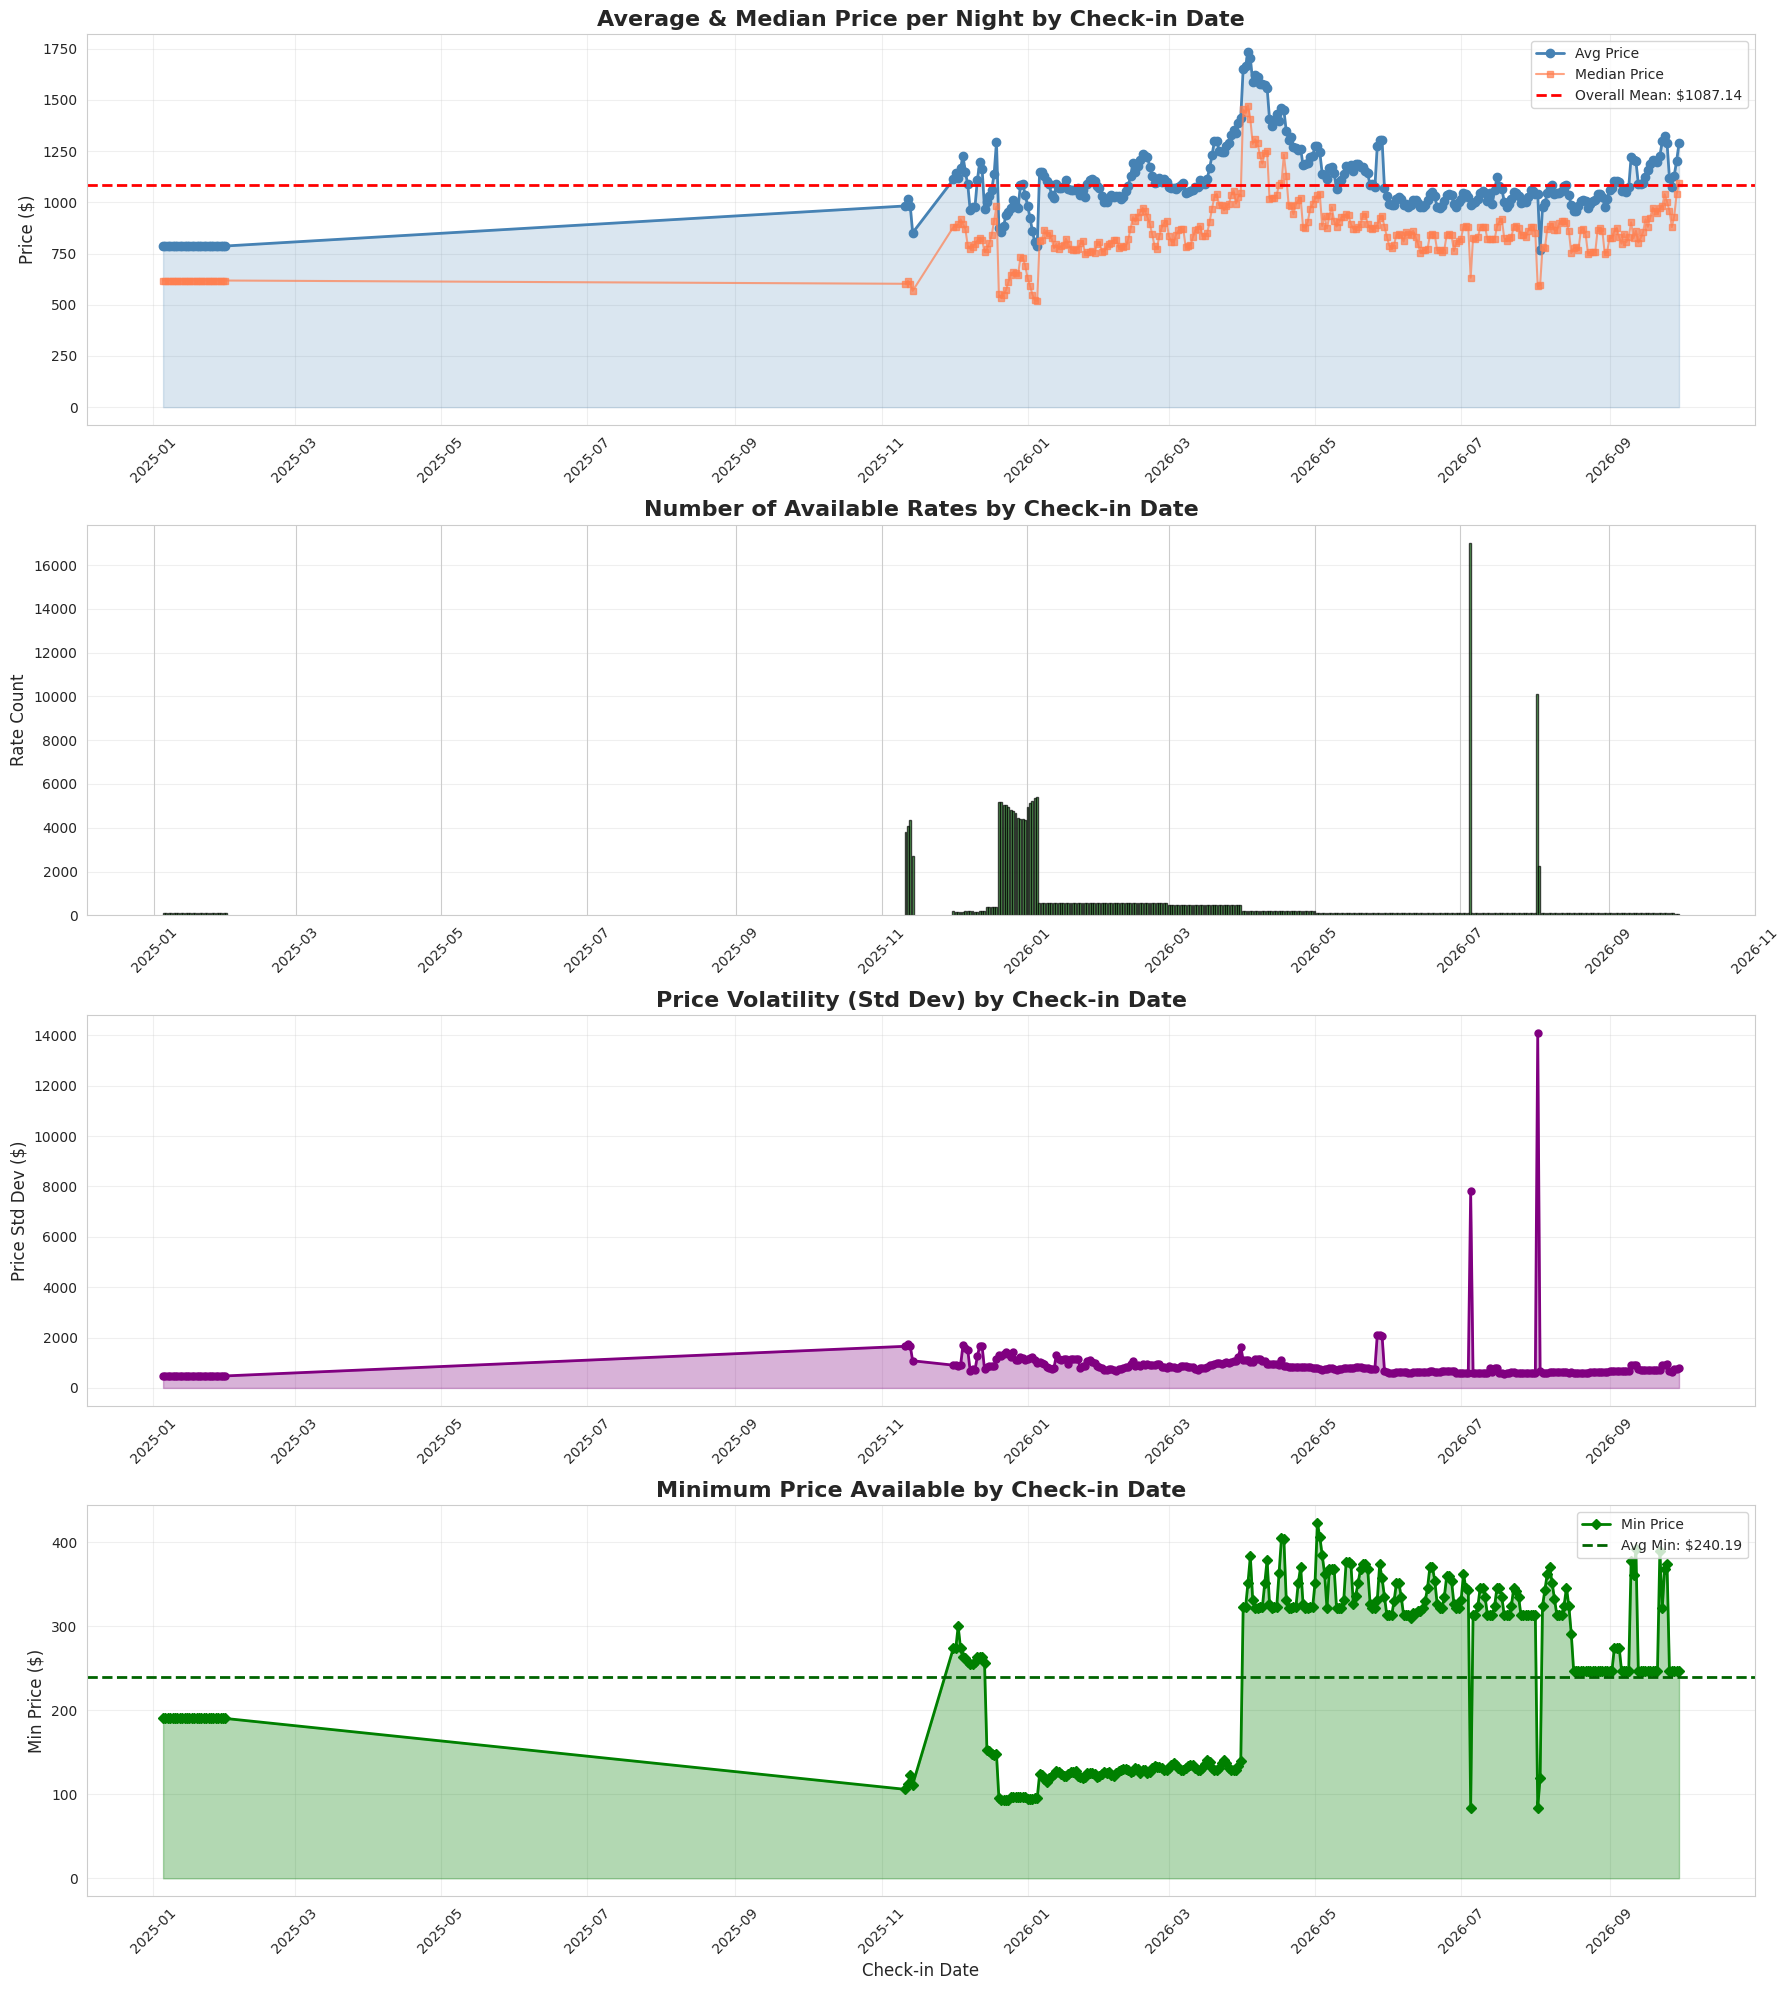

In [26]:
# Comprehensive time-based visualization
fig, axes = plt.subplots(4, 1, figsize=(18, 20))

# 1. Average price over time with trend
axes[0].plot(temporal_df.index, temporal_df['avg_price'], marker='o', linewidth=2, 
             color='steelblue', label='Avg Price', markersize=6)
axes[0].plot(temporal_df.index, temporal_df['median_price'], marker='s', linewidth=1.5, 
             color='coral', alpha=0.7, label='Median Price', markersize=4)
axes[0].fill_between(temporal_df.index, temporal_df['avg_price'], alpha=0.2, color='steelblue')
axes[0].axhline(temporal_df['avg_price'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Overall Mean: ${temporal_df["avg_price"].mean():.2f}')
axes[0].set_title('Average & Median Price per Night by Check-in Date', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. Number of available rates
axes[1].bar(temporal_df.index, temporal_df['rate_count'], alpha=0.7, color='forestgreen', edgecolor='black')
axes[1].set_title('Number of Available Rates by Check-in Date', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Rate Count', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

# 3. Price volatility (std dev)
axes[2].plot(temporal_df.index, temporal_df['price_std'], marker='o', linewidth=2, 
             color='purple', markersize=5)
axes[2].fill_between(temporal_df.index, temporal_df['price_std'], alpha=0.3, color='purple')
axes[2].set_title('Price Volatility (Std Dev) by Check-in Date', fontsize=16, fontweight='bold')
axes[2].set_ylabel('Price Std Dev ($)', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

# 4. Minimum price available
axes[3].plot(temporal_df.index, temporal_df['min_price'], marker='D', linewidth=2, 
             color='green', markersize=5, label='Min Price')
axes[3].fill_between(temporal_df.index, temporal_df['min_price'], alpha=0.3, color='green')
axes[3].axhline(temporal_df['min_price'].mean(), color='darkgreen', linestyle='--', linewidth=2,
                label=f'Avg Min: ${temporal_df["min_price"].mean():.2f}')
axes[3].set_title('Minimum Price Available by Check-in Date', fontsize=16, fontweight='bold')
axes[3].set_ylabel('Min Price ($)', fontsize=12)
axes[3].set_xlabel('Check-in Date', fontsize=12)
axes[3].legend(loc='upper right')
axes[3].grid(True, alpha=0.3)
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


📊 DAY OF WEEK ANALYSIS:
          avg_price         rate_count min_price
               mean     std        sum      mean
day_name                                        
Monday      1051.44  164.13      27372    228.36
Tuesday     1071.98  156.15      24138    233.88
Wednesday   1093.51  171.80      23962    238.86
Thursday    1111.70  170.63      24540    249.89
Friday      1119.31  185.62      23060    251.68
Saturday    1107.35  176.08      25023    253.32
Sunday      1055.04  159.68      51905    225.75


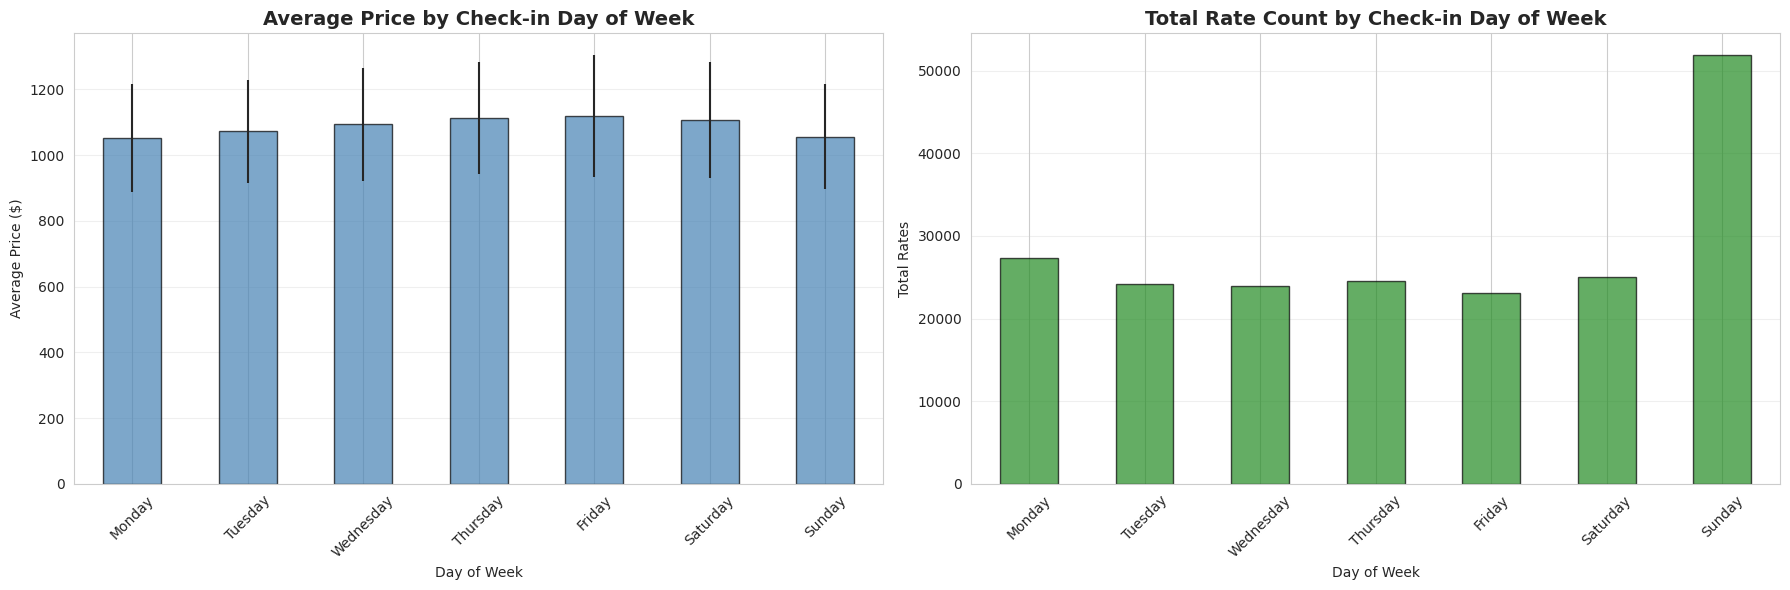


💡 INSIGHT: Cheapest check-in day: Monday ($1051.44)
💡 INSIGHT: Most expensive check-in day: Friday ($1119.31)


In [27]:
# Day of week analysis
dow_analysis = temporal_df.groupby('day_name').agg({
    'avg_price': ['mean', 'std'],
    'rate_count': 'sum',
    'min_price': 'mean'
}).round(2)

# Reorder by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_analysis = dow_analysis.reindex([d for d in day_order if d in dow_analysis.index])

print("\n📊 DAY OF WEEK ANALYSIS:")
print("="*80)
print(dow_analysis)

# Visualize day of week patterns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Average price by day
dow_analysis[('avg_price', 'mean')].plot(kind='bar', ax=axes[0], color='steelblue', 
                                           alpha=0.7, edgecolor='black', yerr=dow_analysis[('avg_price', 'std')])
axes[0].set_title('Average Price by Check-in Day of Week', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average Price ($)')
axes[0].set_xlabel('Day of Week')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Rate availability by day
dow_analysis[('rate_count', 'sum')].plot(kind='bar', ax=axes[1], color='forestgreen', 
                                          alpha=0.7, edgecolor='black')
axes[1].set_title('Total Rate Count by Check-in Day of Week', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Rates')
axes[1].set_xlabel('Day of Week')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Find best day of week
best_day = dow_analysis[('avg_price', 'mean')].idxmin()
worst_day = dow_analysis[('avg_price', 'mean')].idxmax()
print(f"\n💡 INSIGHT: Cheapest check-in day: {best_day} (${dow_analysis.loc[best_day, ('avg_price', 'mean')]:.2f})")
print(f"💡 INSIGHT: Most expensive check-in day: {worst_day} (${dow_analysis.loc[worst_day, ('avg_price', 'mean')]:.2f})")

In [28]:
# Top 10 best value dates (lowest average price)
best_dates = temporal_df.nsmallest(10, 'avg_price')[['avg_price', 'median_price', 'min_price', 
                                                        'rate_count', 'unique_hotels', 'day_name']]

print("\n🏆 TOP 10 BEST VALUE CHECK-IN DATES (Lowest Avg Price):")
print("="*100)
display(best_dates)

# Top 10 dates with most options
most_options = temporal_df.nlargest(10, 'rate_count')[['rate_count', 'avg_price', 'median_price', 
                                                         'unique_hotels', 'unique_destinations', 'day_name']]

print("\n🏆 TOP 10 DATES WITH MOST OPTIONS:")
print("="*100)
display(most_options)

# Dates with best min prices (absolute cheapest options)
best_min_prices = temporal_df.nsmallest(10, 'min_price')[['min_price', 'avg_price', 'rate_count', 
                                                            'unique_hotels', 'day_name']]

print("\n🏆 TOP 10 DATES WITH LOWEST MINIMUM PRICE:")
print("="*100)
display(best_min_prices)


🏆 TOP 10 BEST VALUE CHECK-IN DATES (Lowest Avg Price):


,avg_price,median_price,min_price,rate_count,unique_hotels,day_name
check_in,,,,,,
2026-08-03,766.86,595.23,119.92,2273,1075,Monday
2025-01-05,786.94,618.40,190.40,93,48,Sunday
2025-01-06,786.94,618.40,190.40,93,48,Monday
2025-01-07,786.94,618.40,190.40,93,48,Tuesday
2025-01-08,786.94,618.40,190.40,93,48,Wednesday
2025-01-09,786.94,618.40,190.40,93,48,Thursday
2025-01-10,786.94,618.40,190.40,93,48,Friday
2025-01-11,786.94,618.40,190.40,93,48,Saturday
2025-01-12,786.94,618.40,190.40,93,48,Sunday



🏆 TOP 10 DATES WITH MOST OPTIONS:


,rate_count,avg_price,median_price,unique_hotels,unique_destinations,day_name
check_in,,,,,,
2026-07-05,16992,988.66,631.92,2374,164,Sunday
2026-08-02,10122,1041.63,590.45,2453,161,Sunday
2026-01-05,5401,787.63,519.10,2354,162,Monday
2026-01-04,5374,805.95,521.41,2344,161,Sunday
2026-01-03,5239,859.58,550.13,2290,157,Saturday
2025-12-20,5197,877.26,551.63,2365,155,Saturday
2025-12-21,5175,854.89,532.32,2352,154,Sunday
2026-01-02,5132,924.61,592.26,2252,155,Friday
2025-12-22,5047,886.44,549.90,2291,154,Monday



🏆 TOP 10 DATES WITH LOWEST MINIMUM PRICE:


,min_price,avg_price,rate_count,unique_hotels,day_name
check_in,,,,,
2026-07-05,84.14,988.66,16992,2374,Sunday
2026-08-02,84.14,1041.63,10122,2453,Sunday
2025-12-21,93.58,854.89,5175,2352,Sunday
2025-12-22,93.58,886.44,5047,2291,Monday
2025-12-23,93.58,938.12,5029,2279,Tuesday
2025-12-24,93.58,954.91,4939,2248,Wednesday
2026-01-01,94.82,984.04,4956,2189,Thursday
2026-01-02,94.82,924.61,5132,2252,Friday
2026-01-03,94.82,859.58,5239,2290,Saturday


## 9. Temporal Analysis by Destination


📍 PRICE TRENDS FOR TOP 5 DESTINATIONS:


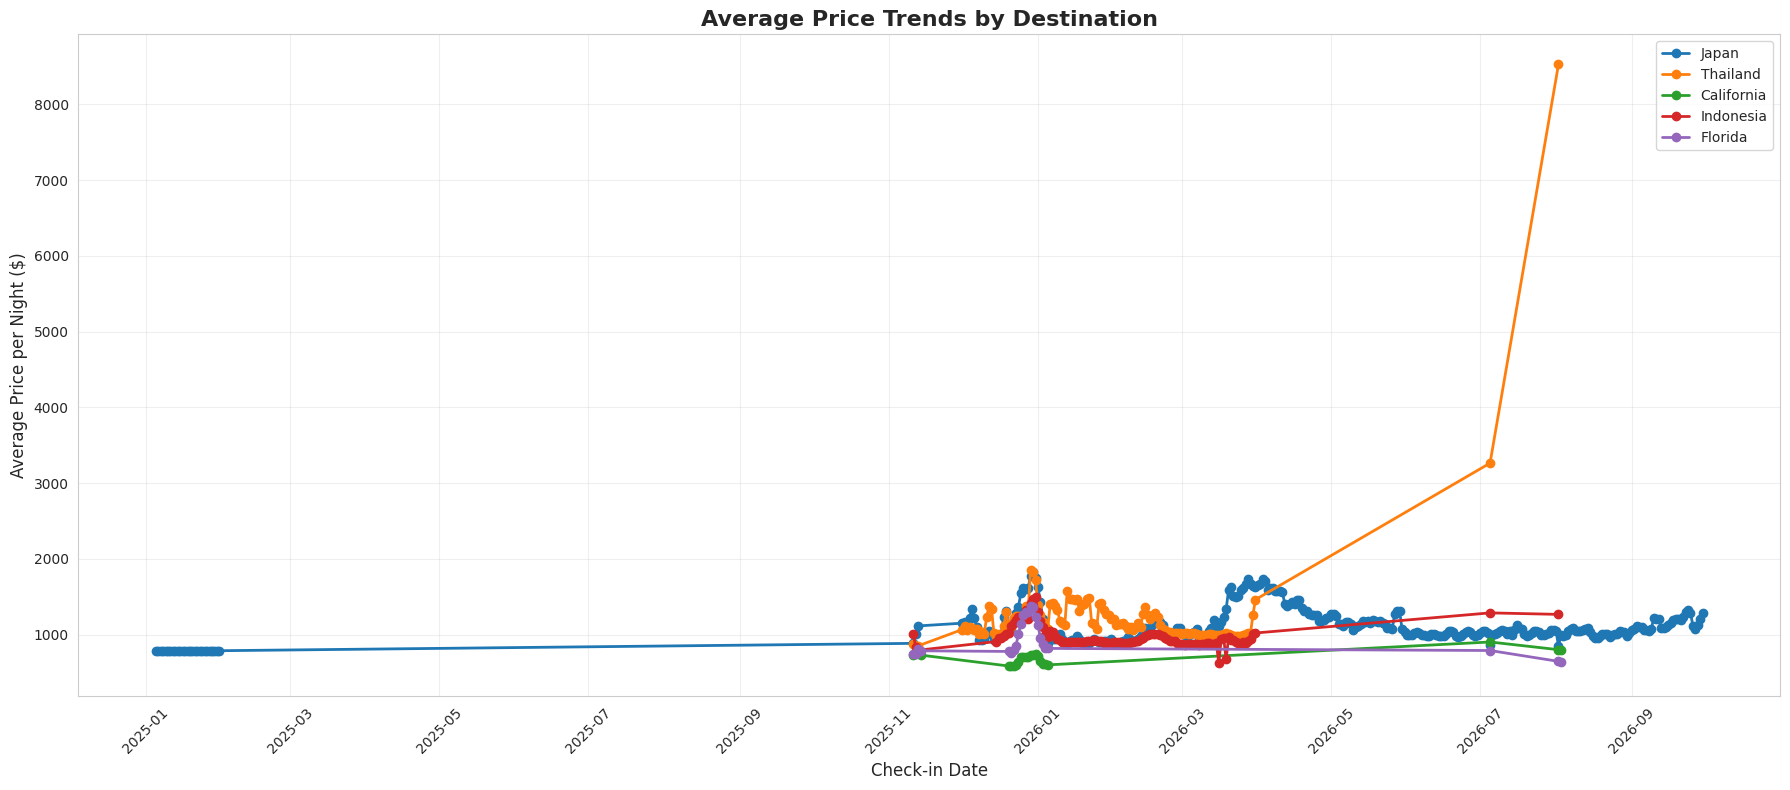


Japan:
  Best date: 2025-01-05 - $786.94/night
  Available rates: 93

Thailand:
  Best date: 2025-11-12 - $830.84/night
  Available rates: 121

California:
  Best date: 2025-12-20 - $585.16/night
  Available rates: 359

Indonesia:
  Best date: 2026-03-16 - $623.60/night
  Available rates: 24

Florida:
  Best date: 2026-08-03 - $644.10/night
  Available rates: 238


In [29]:
# Price trends by destination
dest_temporal = rates_df.groupby(['destination_name', rates_df['check_in'].dt.date]).agg({
    'price_per_night_inclusive': 'mean',
    'snapshot_id': 'count'
}).reset_index()
dest_temporal.columns = ['destination', 'check_in', 'avg_price', 'rate_count']
dest_temporal['check_in'] = pd.to_datetime(dest_temporal['check_in'])

# Get top 5 destinations by rate count
top_destinations = rates_df['destination_name'].value_counts().head(5).index.tolist()

print(f"\n📍 PRICE TRENDS FOR TOP 5 DESTINATIONS:")
print("="*80)

# Plot price trends for top destinations
fig, ax = plt.subplots(figsize=(18, 8))

for dest in top_destinations:
    dest_data = dest_temporal[dest_temporal['destination'] == dest].sort_values('check_in')
    ax.plot(dest_data['check_in'], dest_data['avg_price'], marker='o', linewidth=2, 
            label=dest, markersize=6)

ax.set_title('Average Price Trends by Destination', fontsize=16, fontweight='bold')
ax.set_xlabel('Check-in Date', fontsize=12)
ax.set_ylabel('Average Price per Night ($)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Best dates for each top destination
for dest in top_destinations:
    dest_data = dest_temporal[dest_temporal['destination'] == dest].sort_values('avg_price')
    if len(dest_data) > 0:
        best_date = dest_data.iloc[0]
        print(f"\n{dest}:")
        print(f"  Best date: {best_date['check_in'].strftime('%Y-%m-%d')} - ${best_date['avg_price']:.2f}/night")
        print(f"  Available rates: {best_date['rate_count']:.0f}")

## 10. Temporal Analysis by Collection Type


🏨 PRICE TRENDS BY COLLECTION TYPE:


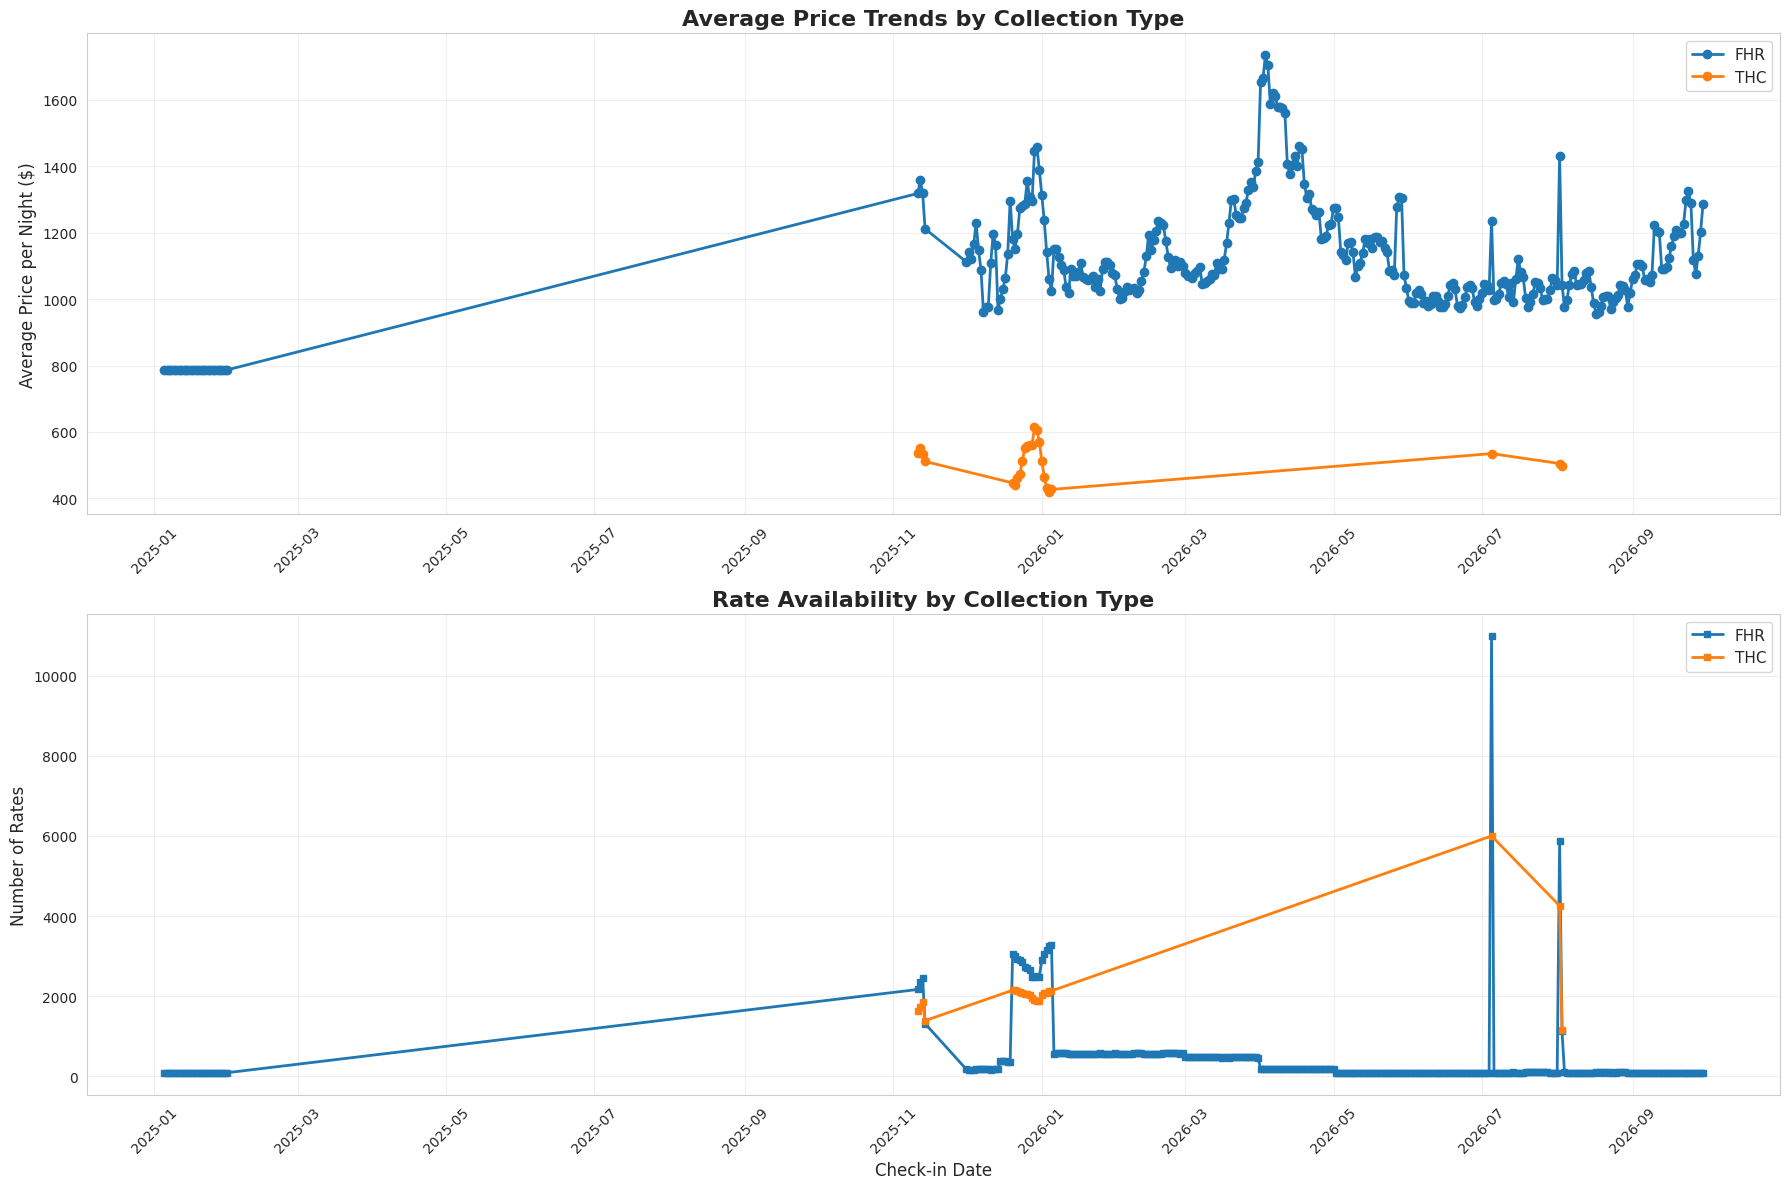

In [30]:
# Price trends by collection type
collection_temporal = rates_df.groupby(['collection_type', rates_df['check_in'].dt.date]).agg({
    'price_per_night_inclusive': 'mean',
    'snapshot_id': 'count'
}).reset_index()
collection_temporal.columns = ['collection', 'check_in', 'avg_price', 'rate_count']
collection_temporal['check_in'] = pd.to_datetime(collection_temporal['check_in'])

print(f"\n🏨 PRICE TRENDS BY COLLECTION TYPE:")
print("="*80)

# Plot price trends by collection
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Average price
for collection in ['FHR', 'THC', 'Standard']:
    coll_data = collection_temporal[collection_temporal['collection'] == collection].sort_values('check_in')
    if len(coll_data) > 0:
        axes[0].plot(coll_data['check_in'], coll_data['avg_price'], marker='o', linewidth=2, 
                    label=collection, markersize=6)

axes[0].set_title('Average Price Trends by Collection Type', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Average Price per Night ($)', fontsize=12)
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Rate availability
for collection in ['FHR', 'THC', 'Standard']:
    coll_data = collection_temporal[collection_temporal['collection'] == collection].sort_values('check_in')
    if len(coll_data) > 0:
        axes[1].plot(coll_data['check_in'], coll_data['rate_count'], marker='s', linewidth=2, 
                    label=collection, markersize=5)

axes[1].set_title('Rate Availability by Collection Type', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Check-in Date', fontsize=12)
axes[1].set_ylabel('Number of Rates', fontsize=12)
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 11. Export Temporal Insights

In [31]:
# Export temporal analysis
output_dir = Path('../data/exports')
output_dir.mkdir(parents=True, exist_ok=True)

# Export temporal summary
temporal_df.to_csv(output_dir / 'temporal_analysis_by_date.csv')
print(f"✅ Exported temporal analysis to: {output_dir / 'temporal_analysis_by_date.csv'}")

# Export day of week analysis
dow_analysis.to_csv(output_dir / 'day_of_week_analysis.csv')
print(f"✅ Exported day of week analysis to: {output_dir / 'day_of_week_analysis.csv'}")

# Export destination temporal
dest_temporal.to_csv(output_dir / 'destination_temporal_analysis.csv', index=False)
print(f"✅ Exported destination temporal to: {output_dir / 'destination_temporal_analysis.csv'}")

# Export collection temporal
collection_temporal.to_csv(output_dir / 'collection_temporal_analysis.csv', index=False)
print(f"✅ Exported collection temporal to: {output_dir / 'collection_temporal_analysis.csv'}")

✅ Exported temporal analysis to: ../data/exports/temporal_analysis_by_date.csv
✅ Exported day of week analysis to: ../data/exports/day_of_week_analysis.csv
✅ Exported destination temporal to: ../data/exports/destination_temporal_analysis.csv
✅ Exported collection temporal to: ../data/exports/collection_temporal_analysis.csv


In [32]:
# Close database connection
conn.close()
print("\n✓ Database connection closed")
print(f"\n✅ Analysis complete! Analyzed {len(rates_df):,} rate snapshots.")


✓ Database connection closed

✅ Analysis complete! Analyzed 200,000 rate snapshots.
